In [121]:
# import data
from BidataGen import sample_p
from model import LBFIS
from BidataGen import bh_HF as HF
from BidataGen import bh_LF as LF
from BidataGen import sample_p_bh as sample
import numpy as np
import matplotlib.pyplot as plt
import torch

torch.manual_seed(0)

806.86633 1013.95593


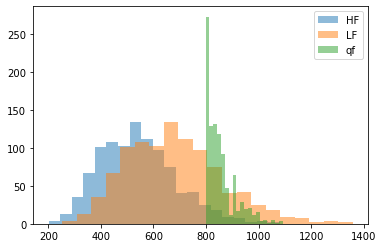

In [132]:
num_variable = 8
#sample = sample_p_bh(n, num_variable)
X = sample(1000)
hf, lf = HF(X).detach().numpy(), LF(X).detach().numpy()
qf = HF(q_lst[:1000]).detach().numpy()
plt.hist(hf, bins=20, alpha=0.5, label='HF')
plt.hist(lf, bins=20, alpha=0.5, label='LF')
plt.hist(qf, bins=20, alpha=0.5, label='qf')
plt.legend(loc='upper right')

print(np.sort(hf)[950], np.sort(lf)[950])

In [123]:
def h_LF(x):
    ind1 = (x[:,:2] < -10).any(axis=1) + (x[:,:2] > 10).any(axis=1)
    ind2 = (x[:,2:] < -1).any(axis=1) + (x[:,2:] > 1).any(axis=1)
    ans = 1000 - LF(x)
    ans[ind1] = torch.norm(x[ind1], dim=1)**2
    ans[ind2] = 100 * torch.norm(x[ind2], dim=1)**2
    return ans
def h_HF(x):
    ind1 = (x[:,:2] < -10).any(axis=1) + (x[:,:2] > 10).any(axis=1)
    ind2 = (x[:,2:] < -1).any(axis=1) + (x[:,2:] > 1).any(axis=1)
    ans = 800 - HF(x)
    ans[ind1] = torch.norm(x[ind1], dim=1)**2
    ans[ind2] = 100 * torch.norm(x[ind2], dim=1)**2
    return ans

# h_LF = h_HF

The probability of h_HF < 0 is:  0.054994
The value of ell is:  tensor(5.7975)


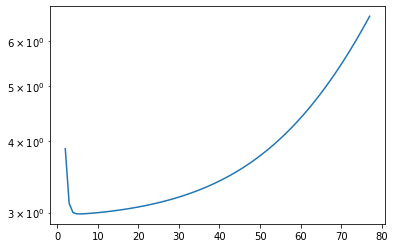

In [124]:
# selcting optimal ell
L = int(1e3)
M = int(1e6)
# fix samples
samps_M = sample(M)
samps_L = sample(L)
h_samps_M = h_LF(samps_M)
h_samps_L = h_LF(samps_L)
h_samps_LL = h_LF(samps_L)

ExH = np.mean((h_HF(samps_M) < 0).detach().numpy())
print("The probability of h_HF < 0 is: ", ExH)

def Zl(ell):
    return (-ell * torch.tanh(h_samps_M)).exp().sum() / M
def V(ell):
    return Zl(ell) * ((ell * torch.tanh(h_samps_LL)).exp()[h_samps_L < 0]).sum()

ell_lst = torch.linspace(2, 77, 80)
V_lst = [V(ell).item() for ell in ell_lst]

plt.plot(ell_lst, V_lst)
plt.yscale('log')
if torch.sum(h_samps_L < 0) > 0:
    ell = ell_lst[torch.argmin(torch.tensor(V_lst))]
else:
    ell = 1.0
print("The value of ell is: ", ell)

In [128]:
from tqdm import tqdm
Zc = Zl(ell)
def potential(z: torch.Tensor): # evaluate the potential function for the given z
    return ell * torch.tanh(h_LF(z)) - torch.norm(z[:,0])**2 - torch.norm(z[:,1])**2  

def log_Q(potential, z_prime, z, step):
    z.requires_grad_()
    grad = torch.autograd.grad(potential(z).mean(), z)[0]
    return -(torch.norm(z_prime - z + step * grad, p=2, dim=1) ** 2) / (4 * step)

def metropolis_adjusted_langevin_algorithm(iter_num=1000, step=0.01, burn_in=1000):
    Z0 = torch.zeros(1, num_variable)
    Zi = Z0
    samples = []
    pbar = tqdm(range(iter_num + burn_in))
    for i in pbar:
        Zi.requires_grad_()
        u = potential(Zi).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        prop_Zi = Zi.detach() - step * grad + np.sqrt(2 * step) * torch.randn(1, num_variable)
        log_ratio = -potential(prop_Zi).mean() + potential(Zi).mean() +\
                    log_Q(potential, Zi, prop_Zi, step) - log_Q(potential, prop_Zi, Zi, step)
        if torch.rand(1) < torch.exp(log_ratio):
            Zi = prop_Zi
        samples.append(Zi.detach())
    return torch.cat(samples, 0)[burn_in:]

def weight(x:torch.Tensor): # evaluate the unnormalized weight for the given xi
    wt = Zc * (ell * torch.tanh(h_LF(x))).exp()
    return wt

q_lst = metropolis_adjusted_langevin_algorithm(iter_num=int(1e4), step=1e-3, burn_in=int(1e4))
print('The number of failures sampled by q is ', (h_HF(q_lst) < 0).sum().item())
q_lst2 = q_lst[(q_lst[:,2:] < 1).all(axis=1) * (q_lst[:,2:] > -1).all(axis=1)]
print('The number of meaningful q samples is ', q_lst2.shape[0])


100%|██████████| 20000/20000 [02:51<00:00, 116.67it/s]

The number of failures sampled by q is  9585
The number of meaningful q samples is  10000


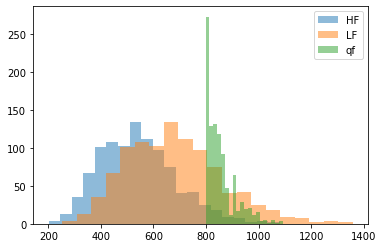

In [133]:
q_lst = q_lst2
qf = HF(q_lst[:1000]).detach().numpy()
plt.hist(hf, bins=20, alpha=0.5, label='HF')
plt.hist(lf, bins=20, alpha=0.5, label='LF')
plt.hist(qf, bins=20, alpha=0.5, label='qf')
plt.legend(loc='upper right')

In [134]:
q_mean, q_smt = (weight(q_lst)[h_HF(q_lst) < 0]).sum()/(len(q_lst)), (weight(q_lst)[h_HF(q_lst) < 0]**2).sum()/(len(q_lst))
print(q_mean)
print(q_smt - q_mean**2)
print(ExH)

tensor(0.0545)
tensor(0.0001)
0.054994


In [131]:
MC_N_lst = (10**np.linspace(1, 4, 10)).astype('int')
MC = []
IS = []
GM = []
num_trial = 1000
num_trial_gm = 10
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    for MC_N in MC_N_lst:
        xi_p = sample(MC_N) # sample MC xi_p
        xi_q = q_lst[np.random.choice(len(q_lst),MC_N)] # sample xi_q
        wt_q = weight(xi_q) / MC_N
        MC_est_lst.append(np.mean((h_HF(xi_p) < 0).detach().numpy()))
        IS_est_lst.append(wt_q[h_HF(xi_q) < 0].sum().item())
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)

# for j in range(num_trial_gm):
#     GM_est_lst = []
#     for MC_N in MC_N_lst:
#         GM_est_lst.append(gaussian_mix(est, h_HF, MC_N))
#     GM.append(GM_est_lst)

MC      = np.array(MC)
IS      = np.array(IS)
GM      = np.array(GM)
MC_mean = np.nanmean(MC, axis=0)
MC_std  = np.nanstd(MC, axis=0)
IS_mean = np.nanmean(IS, axis=0)
IS_std  = np.nanstd(IS, axis=0)
GM_mean = np.nanmean(GM, axis=0)
GM_std  = np.nanstd(GM, axis=0)
MC_err  = ((MC - ExH)**2)
IS_err  = ((IS - ExH)**2)
GM_err  = ((GM - ExH)**2)
MC_rmse = np.sqrt(np.nanmean(MC_err, axis=0))
IS_rmse = np.sqrt(np.nanmean(IS_err, axis=0))
GM_rmse = np.sqrt(np.nanmean(GM_err, axis=0))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


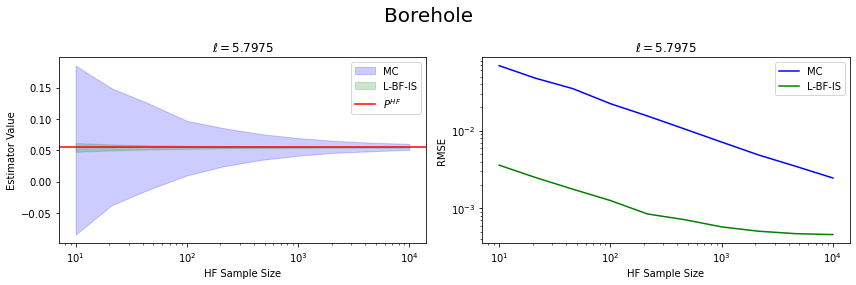

In [135]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Borehole', fontsize=20)
scale = 1.96

axs[0].fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='b',alpha=0.2,label='MC')
axs[0].fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='g',alpha=0.2,label='L-BF-IS')
#axs[0].fill_between(MC_N_lst, GM_mean-scale*GM_std, GM_mean+scale*GM_std,color='r',alpha=0.2,label='GM')
axs[0].axhline(ExH,c='r',label=r'$P^{HF}$')
axs[0].set_xscale('log')
axs[0].set_xlabel('HF Sample Size')
axs[0].set_ylabel('Estimator Value')
axs[0].legend()
axs[0].set_title(f'$\ell={ell:.4f}$')

axs[1].plot(MC_N_lst, MC_rmse,color='b',alpha=1.0,label='MC')
axs[1].plot(MC_N_lst, IS_rmse,color='g',alpha=1.0,label='L-BF-IS')
#axs[1].plot(MC_N_lst, GM_rmse,color='r',alpha=1.0,label='GM')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('HF Sample Size')
axs[1].set_ylabel('RMSE')
axs[1].legend()
axs[1].set_title(f'$\ell={ell:.4f}$')

fig.tight_layout()
# fig.savefig('../figures/borehole.pdf', dpi=300)